# Imports

In [58]:
#importing necessary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import f_classif
import matplotlib
import sklearn
import scipy

# Load Data

In [59]:
path_to_application = '/Users/Kamalesh/Documents/Code_Alpha/Task1/archive-4/application_record.csv'
applicant_data = pd.read_csv(path_to_application)

display(applicant_data.head())
applicant_data.info()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [60]:
path_to_credit = '/Users/Kamalesh/Documents/Code_Alpha/Task1/archive-4/credit_record.csv'
credit_data = pd.read_csv(path_to_credit)

display(credit_data.head())
credit_data.info()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [61]:
credit_data['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

# Merge personal and credit data

Since we have two different tables, merge them to get the one with both personal and credit info.<br>
Also to turn the task into binary classification, I decoded the target variable using the <b>label_status</b> func. Now any days past due are set to 0 and paid in time - 1

In [62]:
applicant_data = applicant_data.drop_duplicates(subset='ID', keep='first')

mode_status = credit_data.groupby('ID')['STATUS'].agg(lambda x: x.mode()[0]).reset_index()
mode_status.rename(columns={'STATUS': 'mode_status'}, inplace=True)
mode_status = mode_status[mode_status['mode_status'] != 'X']

merged_df = pd.merge(applicant_data, mode_status, on='ID', how='inner')

In [63]:
#change the target variable to binary format
def label_status(status):
    if status in {"0", "1", "2", "3", "4", "5"}:
        return 0
    elif status == 'C':
        return 1

In [64]:
merged_df['label'] = merged_df['mode_status'].apply(label_status)
merged_df['label'].value_counts()

label
0    17652
1    12807
Name: count, dtype: int64

In [65]:
merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,mode_status,label
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,C,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,C,1
2,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,C,1
3,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,C,1
4,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,0,0


# Exploratory data analysis

## Encoding categorical features

To prepare data for modeling I encoded all categorical variables using the sklearn instrumentary. Also I convereted the age and years_employed to normal format and filled Nans in 'OCCUPATION_TYPE' with 'Unknown'

In [66]:
#pipeline for category variables encoding

categorical_ordinal_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
categorical_onehot_columns = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']
numerical_columns = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'mode_status']


class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, output_type='numpy'):
        self.output_type = output_type

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X)

        if 'mode_status' in X_df.columns:
            X_df.drop(columns=['mode_status'], inplace=True)

        X_df['AGE'] = abs(X_df['DAYS_BIRTH']) / 365. #change the age to normal format
        X_df['YEARS_EMPLOYED'] = abs(X_df['DAYS_EMPLOYED']) / 365

        X_df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'], inplace=True)

        if self.output_type == 'pandas':
            return X_df
        else:
            return X_df.values

    def set_output(self, transform='numpy'):
        self.output_type = transform
        return self


preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(), categorical_ordinal_columns),

        ('onehot1', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), ['OCCUPATION_TYPE']),

        ('onehot2', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_onehot_columns),
        ('custom', FeatureEngineeringTransformer(output_type='pandas'), numerical_columns)
    ],
    remainder='passthrough'
).set_output(transform='pandas')

In [67]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

merged_df = pipeline.fit_transform(merged_df) #process the data
merged_df.columns = [col.split('__', 1)[-1] for col in merged_df.columns]

In [68]:
merged_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,...,YEARS_EMPLOYED,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,label
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.443836,5008804,0,427500.0,1,1,0,0,2.0,1
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.443836,5008805,0,427500.0,1,1,0,0,2.0,1
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.358904,5008810,0,270000.0,1,0,1,1,1.0,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.358904,5008811,0,270000.0,1,0,1,1,1.0,1
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1000.665753,5008812,0,283500.0,1,0,0,0,1.0,0


check the types to make sure that no object/string types are left

In [69]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30459 entries, 0 to 30458
Data columns (total 54 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   CODE_GENDER                                        30459 non-null  float64
 1   FLAG_OWN_CAR                                       30459 non-null  float64
 2   FLAG_OWN_REALTY                                    30459 non-null  float64
 3   OCCUPATION_TYPE_Accountants                        30459 non-null  float64
 4   OCCUPATION_TYPE_Cleaning staff                     30459 non-null  float64
 5   OCCUPATION_TYPE_Cooking staff                      30459 non-null  float64
 6   OCCUPATION_TYPE_Core staff                         30459 non-null  float64
 7   OCCUPATION_TYPE_Drivers                            30459 non-null  float64
 8   OCCUPATION_TYPE_HR staff                           30459 non-null  float64
 9   OCCUPA

## Correlation analysis

Check high correlated variables, get rid of them

In [70]:
corr_matrix = merged_df.corr()

corr_pairs = corr_matrix.unstack().sort_values(kind="quick", ascending=False)

top_corr_pairs = corr_pairs[corr_pairs < 1].drop_duplicates()

display(top_corr_pairs.head(10))

YEARS_EMPLOYED              NAME_INCOME_TYPE_Pensioner    0.997900
CNT_FAM_MEMBERS             CNT_CHILDREN                  0.889129
OCCUPATION_TYPE_Unknown     YEARS_EMPLOYED                0.669949
                            NAME_INCOME_TYPE_Pensioner    0.668670
AGE                         YEARS_EMPLOYED                0.626161
                            NAME_INCOME_TYPE_Pensioner    0.620995
NAME_FAMILY_STATUS_Married  CNT_FAM_MEMBERS               0.498278
OCCUPATION_TYPE_Unknown     AGE                           0.417198
CODE_GENDER                 FLAG_OWN_CAR                  0.362537
                            OCCUPATION_TYPE_Drivers       0.327564
dtype: float64

In [71]:
merged_df.drop(columns=['NAME_INCOME_TYPE_Pensioner', 'CNT_CHILDREN'], inplace=True)

# Experiment log

The approach I chose is going from simple to complex as I said before.
The 'combined_results' var contains final results, check them at the end

In [72]:
combined_results = pd.DataFrame(columns=['Model', 'Data', 'KFold', 'Extra Features', 'Stat Significant', 'Model Significant', 'Regularization', 'Greed Search', 'roc_auc'])

Help functions

In [73]:
def prepare_data(data, label_col, test_size=0.3, random_state=42):
    X = data.drop(columns=[label_col, 'ID'])
    y = data[label_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return  X_train_scaled, X_test_scaled, y_train, y_test

In [74]:
def evaluate_model(model, data, random_state=42):

    X_train, X_test, y_train, y_test = data

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"{model.__class__.__name__} Results:")
    print()
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc)

    return model, roc_auc

## Experiment1. Baseline

First let's build the model on raw data to see the base performance

In [75]:
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(merged_df, 'label')

prepared_data = X_train_scaled, X_test_scaled, y_train, y_test
log_reg = LogisticRegression(max_iter=1000, random_state=42)

_, score = evaluate_model(log_reg, prepared_data)

LogisticRegression Results:

Confusion Matrix:
 [[5254   63]
 [3760   61]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.99      0.73      5317
           1       0.49      0.02      0.03      3821

    accuracy                           0.58      9138
   macro avg       0.54      0.50      0.38      9138
weighted avg       0.54      0.58      0.44      9138

Accuracy Score: 0.5816371197198512
ROC AUC Score: 0.5020578101566642


In [76]:
combined_results = pd.concat([combined_results, pd.DataFrame([{'Model': 'Logistic Regression', 'Data': 'base', 'KFold': '-', 'Extra Features': '-', 'Stat Significant': '-', 'Model Significant': '-', 'Regularization':'-', 'Greed Search': '-', 'roc_auc': f"{score}"}])], ignore_index=True)

## Experiment 2. Add KFold validation

Kfold validation on raw data already improved the performance

In [77]:
log_reg = LogisticRegression(max_iter=1000,  random_state=42)

roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=kf, scoring=roc_auc_scorer)
print(f"K-Fold Cross-Validation ROC AUC Scores: {kf_scores}")
print(f"Average ROC AUC (K-Fold): {kf_scores.mean()}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


K-Fold Cross-Validation ROC AUC Scores: [0.51827686 0.53391865 0.52809144 0.52336026 0.51470824]
Average ROC AUC (K-Fold): 0.5236710872343269


In [78]:
combined_results = pd.concat([combined_results, pd.DataFrame([{'Model': 'Logistic Regression', 'Data': 'base', 'KFold': 5, 'Extra Features': '-', 'Stat Significant': '-', 'Model Significant': '-', 'Regularization':'-', 'Greed Search': '-', 'roc_auc': kf_scores.mean()}])], ignore_index=True)

## Experiment 3. Adding new features

Since the performance is bad, I add more features that might be helpful

In [79]:
#adding income per family member and employed to age ratio

merged_df['INCOME_PER_FAM_MEMBER'] = merged_df['AMT_INCOME_TOTAL'] / merged_df['CNT_FAM_MEMBERS']
merged_df['EMPLOYED_TO_AGE_RATIO'] = merged_df['YEARS_EMPLOYED'] / merged_df['AGE']

In [80]:
#adding the credit history length and the recent activity (<=4 month ago)
credit_history_length = credit_data.groupby('ID')['MONTHS_BALANCE'].apply(lambda x: x.max() - x.min()).reset_index()
credit_history_length.columns = ['ID', 'CREDIT_HISTORY_LENGTH']
merged_df = pd.merge(merged_df, credit_history_length, on='ID', how='left')

def recent_activity(months_balance):
    return 1 if any(month >= -4 for month in months_balance) else 0

recent_activity_flag = credit_data.groupby('ID')['MONTHS_BALANCE'].apply(recent_activity).reset_index()
recent_activity_flag.columns = ['ID', 'RECENT_ACTIVITY']

merged_df = pd.merge(merged_df, recent_activity_flag, on='ID', how='left')

Using pair plots to see if new features help


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

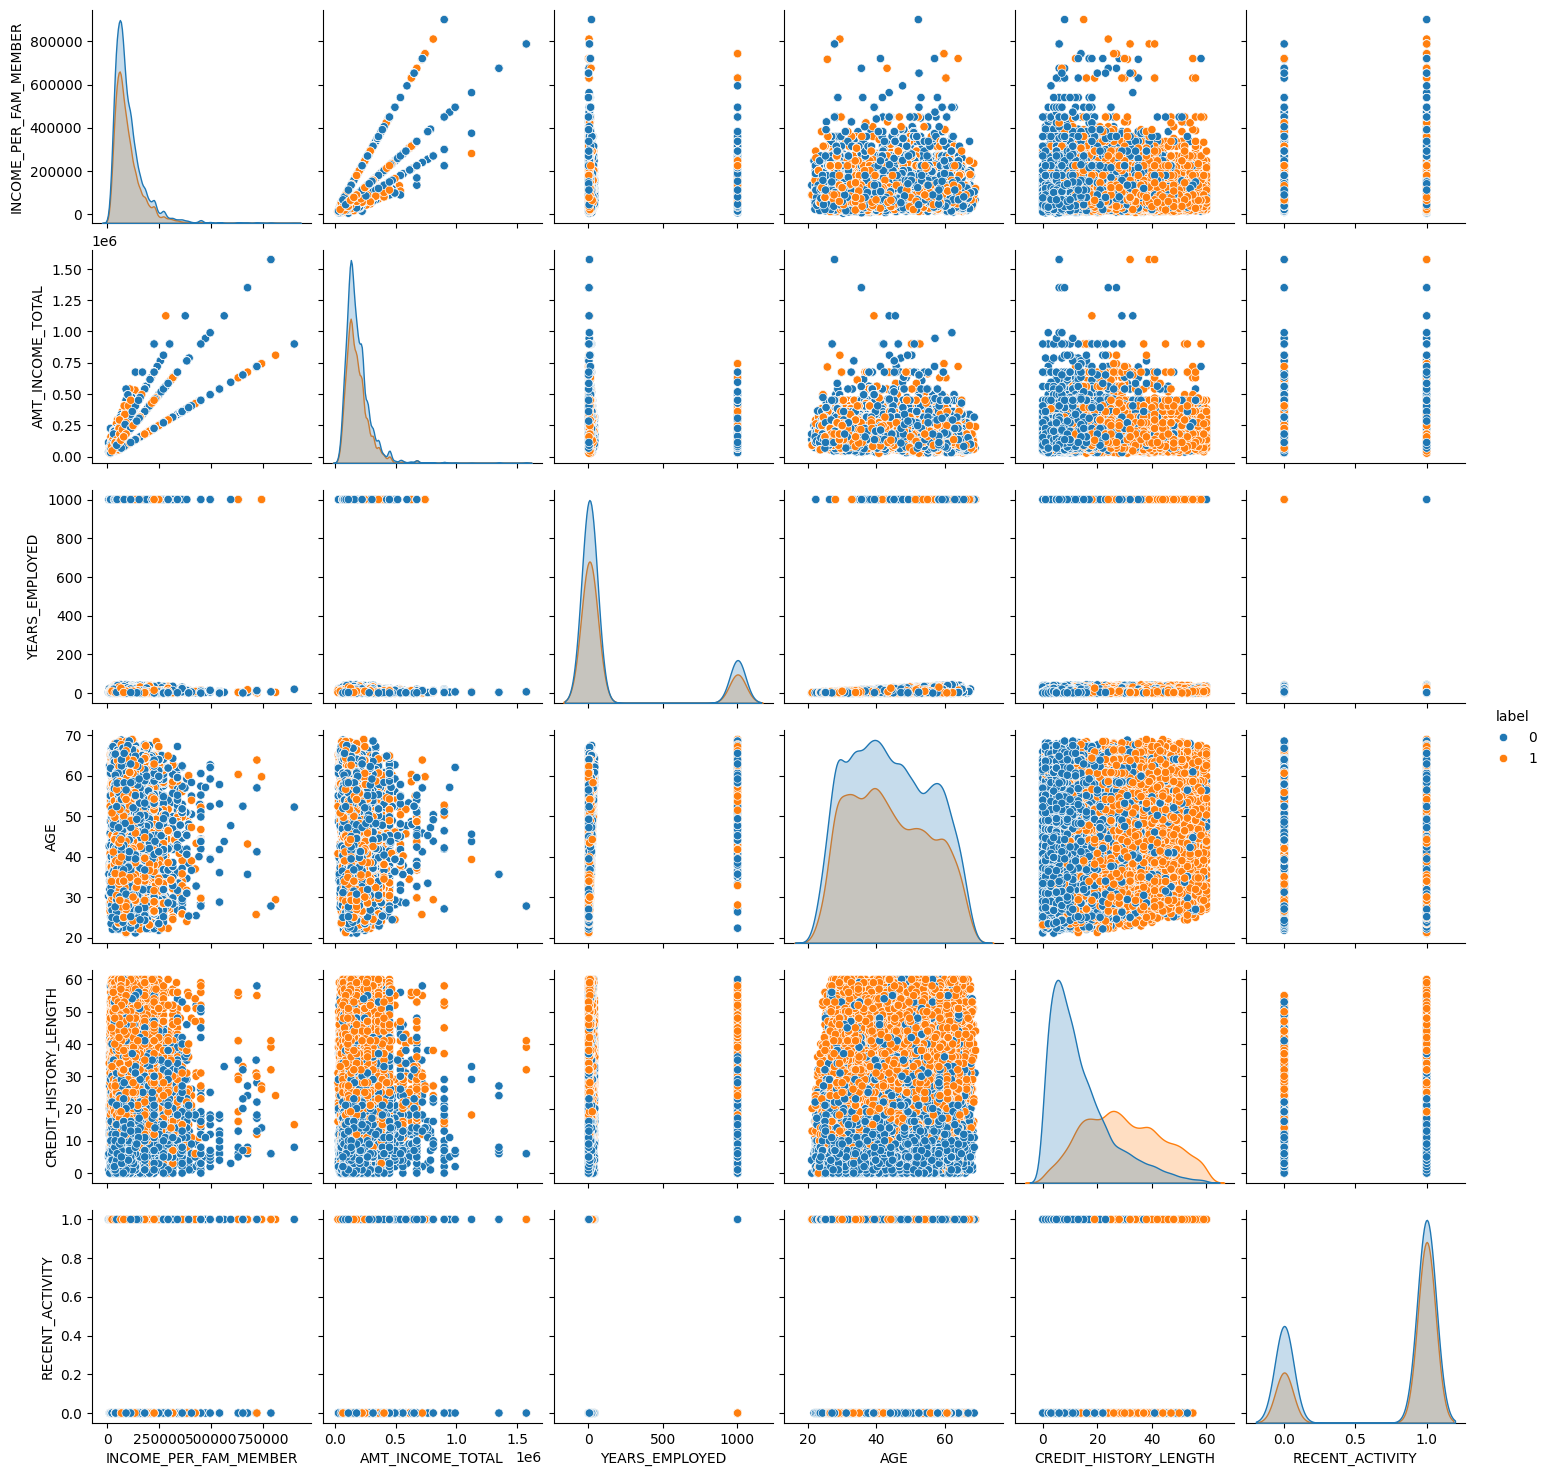

In [81]:
selected_columns = [
    'INCOME_PER_FAM_MEMBER', 'AMT_INCOME_TOTAL', 'YEARS_EMPLOYED',
    'AGE', 'CREDIT_HISTORY_LENGTH', 'RECENT_ACTIVITY', 'label'
]

sns.pairplot(merged_df[selected_columns], hue='label')
plt.show()

In [82]:
#adding poly features
selected_features = [
    'INCOME_PER_FAM_MEMBER', 'AMT_INCOME_TOTAL', 'YEARS_EMPLOYED',
    'AGE', 'CREDIT_HISTORY_LENGTH', 'RECENT_ACTIVITY'
]

poly = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly.fit_transform(merged_df[selected_features])
poly_feature_names = poly.get_feature_names_out(selected_features)

X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)

merged_df_with_poly = pd.concat([merged_df, X_poly_df], axis=1)

Building the model with new features


In [83]:
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(merged_df_with_poly, 'label')

prepared_data = X_train_scaled, X_test_scaled, y_train, y_test

log_reg = LogisticRegression(max_iter=1000, random_state=42)

_, score = evaluate_model(log_reg, prepared_data)

LogisticRegression Results:

Confusion Matrix:
 [[4275 1042]
 [1216 2605]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79      5317
           1       0.71      0.68      0.70      3821

    accuracy                           0.75      9138
   macro avg       0.75      0.74      0.74      9138
weighted avg       0.75      0.75      0.75      9138

Accuracy Score: 0.7528999781133727
ROC AUC Score: 0.7428917639701054


In [84]:
combined_results = pd.concat([combined_results, pd.DataFrame([{'Model': 'Logistic Regression', 'Data': 'with extra features', 'KFold': '-', 'Extra Features': '+', 'Stat Significant': '-', 'Model Significant': '-', 'Regularization':'-', 'Greed Search': '-', 'roc_auc': f"{score}"}])], ignore_index=True)

## Experiment 4. Stat significant features

For futher performance improving I will try to remove unnecessary fetures that might mislead the model

Using the F-test and a T-test to check the significance.

In [85]:
merged_df_with_poly = merged_df_with_poly.loc[:, ~merged_df_with_poly.columns.duplicated()]

In [86]:
def fisher_test_for_categorical(feature):
    if merged_df_with_poly[feature].ndim == 1:
        contingency_table = pd.crosstab(merged_df_with_poly[feature], merged_df_with_poly['label'])
        if contingency_table.shape == (2, 2):
            odds_ratio, p_value = stats.fisher_exact(contingency_table)
            return p_value
    return None

def t_test_and_f_stat_for_numeric(feature):
    group_0 = merged_df_with_poly[merged_df_with_poly['label'] == 0][feature]
    group_1 = merged_df_with_poly[merged_df_with_poly['label'] == 1][feature]

    t_stat, p_value_ttest = stats.ttest_ind(group_0, group_1)

    X = merged_df_with_poly[[feature]]
    y = merged_df_with_poly['label']
    f_stat, p_value_f_stat = f_classif(X, y)

    return p_value_ttest, f_stat[0], p_value_f_stat[0]

def test_features(df, features):
    results = []
    for feature in features:
      if feature in ('ID' , 'label'):
        continue
      if pd.api.types.is_numeric_dtype(df[feature]):
          p_value_ttest, f_stat, p_value_f_stat = t_test_and_f_stat_for_numeric(feature)
          results.append({
              'Feature': feature,
              'Test': 'T-test and F-stat',
              'T-test p-value': p_value_ttest,
              'F-stat': f_stat,
              'F-stat p-value': p_value_f_stat
          })
      elif isinstance(df[feature].dtype, pd.CategoricalDtype) or df[feature].nunique() <= 2:
          p_value_fisher = fisher_test_for_categorical(feature)
          if p_value_fisher is not None:
              results.append({
                  'Feature': feature,
                  'Test': 'Fisher Exact Test',
                  'Fisher Exact Test p-value': p_value_fisher
              })
          else:
              results.append({
                  'Feature': feature,
                  'Test': 'Fisher Exact Test not applicable'
              })

    return pd.DataFrame(results)

features = list(merged_df_with_poly.columns)
results_df = test_features(merged_df_with_poly, features)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Leaving only variables with p-value < 0.05


In [87]:
significant_features = results_df[(results_df['T-test p-value'] < 0.05) | (results_df['F-stat p-value'] < 0.05)].reset_index(drop=True)

In [88]:
significant_features

,Feature,Test,T-test p-value,F-stat,F-stat p-value
0,FLAG_OWN_REALTY,T-test and F-stat,9.142434e-03,6.795658,9.142434e-03
1,OCCUPATION_TYPE_Cooking staff,T-test and F-stat,3.426365e-03,8.566613,3.426365e-03
2,OCCUPATION_TYPE_High skill tech staff,T-test and F-stat,3.446652e-02,4.471813,3.446652e-02
3,OCCUPATION_TYPE_Laborers,T-test and F-stat,5.982790e-03,7.556540,5.982790e-03
4,OCCUPATION_TYPE_Low-skill Laborers,T-test and F-stat,2.714611e-02,4.881965,2.714611e-02
5,OCCUPATION_TYPE_Private service staff,T-test and F-stat,2.006378e-02,5.406906,2.006378e-02
6,OCCUPATION_TYPE_Realty agents,T-test and F-stat,2.309752e-04,13.563908,2.309752e-04
7,OCCUPATION_TYPE_Sales staff,T-test and F-stat,1.499678e-02,5.917518,1.499678e-02
8,OCCUPATION_TYPE_Security staff,T-test and F-stat,3.233907e-03,8.671943,3.233907e-03
9,OCCUPATION_TYPE_Waiters/barmen staff,T-test and F-stat,3.320580e-03,8.623740,3.320580e-03


In [89]:
significant_features_list = significant_features['Feature'].tolist()
significant_features_list.append('ID')
significant_features_list.append('label')

stat_sig_df = merged_df_with_poly[significant_features_list]

With less the features the result is +- the same

In [90]:
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(stat_sig_df, 'label')

prepared_data = X_train_scaled, X_test_scaled, y_train, y_test

log_reg = LogisticRegression(max_iter=1000, random_state=42)

_, score = evaluate_model(log_reg, prepared_data)

LogisticRegression Results:

Confusion Matrix:
 [[4273 1044]
 [1229 2592]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79      5317
           1       0.71      0.68      0.70      3821

    accuracy                           0.75      9138
   macro avg       0.74      0.74      0.74      9138
weighted avg       0.75      0.75      0.75      9138

Accuracy Score: 0.7512584810680674
ROC AUC Score: 0.7410025626275549


In [91]:
combined_results = pd.concat([combined_results, pd.DataFrame([{'Model': 'Logistic Regression', 'Data': 'stat significant', 'KFold': '-', 'Extra Features': '+', 'Stat Significant': '+', 'Model Significant': '-', 'Regularization':'-', 'Greed Search': '-', 'roc_auc': f"{score}"}])], ignore_index=True)

## Experimnet 5. Model significant features

Use the Logit model to evaluate the features importance

In [92]:
X = merged_df_with_poly.drop(columns=['label', 'ID'])
y = merged_df_with_poly['label']

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
logit_model = sm.Logit(y_train, X_train)

result = logit_model.fit()

display(result.summary())

Optimization terminated successfully.
         Current function value: 0.513147
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                21321
Model:                          Logit   Df Residuals:                    21247
Method:                           MLE   Df Model:                           73
Date:                Sun, 10 Nov 2024   Pseudo R-squ.:                  0.2462
Time:                        13:17:10   Log-Likelihood:                -10941.
converged:                       True   LL-Null:                       -14514.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
CODE_GENDER                                          -0.0064      0.045     -0.142      0.887      -0.095       0.082
FLAG_OWN_CAR                                         -0.1033      0.037     -2.758      0.006      -0.177      -0.030
FLAG_OWN_REALTY                                       0.1056      0.038      2.814      0.005       0.032       0.179
OCCUPATION_TYPE_Accountants                           0.0741   1.02e+04   7.24e-06      1.000   -2.01e+04    2.01e+04
OCCUPATION_TYPE_Cleaning staff                       -0.0031   9011.600  -3.43e-07      1.000   -1.77e+04    1.77e+04
OCCUPATION_TYPE_Cooking staff                        -0.2270        nan        nan        nan         nan         nan
OCCUPATION_TYPE_Core staff                           -0.0010   8.99e+04  -1.11e-08      1.000   -1.76e+05    1.76e+05
OCCUPATION_TYPE_Drivers                               0.0880   1.12e+05   7.87e-07      1.000   -2.19e+05    2.19e+05
OCCUPATION_TYPE_HR staff                             -0.5329        nan        nan        nan         nan         nan
OCCUPATION_TYPE_High skill tech staff                 0.0749   7.28e+04   1.03e-06      1.000   -1.43e+05    1.43e+05
OCCUPATION_TYPE_IT staff                              0.1922   7.87e+04   2.44e-06      1.000   -1.54e+05    1.54e+05
OCCUPATION_TYPE_Laborers                              0.1806    1.1e+05   1.64e-06      1.000   -2.15e+05    2.15e+05
OCCUPATION_TYPE_Low-skill Laborers                    0.6209        nan        nan        nan         nan         nan
OCCUPATION_TYPE_Managers                             -0.0540   6.38e+04  -8.46e-07      1.000   -1.25e+05    1.25e+05
OCCUPATION_TYPE_Medicine staff                        0.1343   2.03e+05   6.62e-07      1.000   -3.97e+05    3.97e+05
OCCUPATION_TYPE_Private service staff                -0.2242        nan        nan        nan         nan         nan
OCCUPATION_TYPE_Realty agents                        -0.7014        nan        nan        nan         nan         nan
OCCUPATION_TYPE_Sales staff                           0.0293   7.79e+04   3.76e-07      1.000   -1.53e+05    1.53e+05
OCCUPATION_TYPE_Secretaries                          -0.0677   1.47e+05   -4.6e-07      1.000   -2.89e+05    2.89e+05
OCCUPATION_TYPE_Security staff                       -0.3357   1.05e+05   -3.2e-06      1.000   -2.06e+05    2.06e+05
OCCUPATION_TYPE_Unknown                               0.0422   8.85e+04   4.77e-07      1.000   -1.73e+05    1.73e+05
OCCUPATION_TYPE_Waiters/barmen staff                 -0.0960   3.39e+05  -2.84e-07      1.000   -6.64e+05    6.64e+05
NAME_INCOME_TYPE_Commercial associate                 0.2954      0.478      0.618      0.537      -0.642       1.232
NAME_INCOME_TYPE_State servant                        0.2972      0.719      0.414      0.679      -1.111       1.706
NAME_INCOME_TYPE_Student                              0

Only 8 features left

In [93]:
summary_table = result.summary2().tables[1]

significant_features = summary_table[summary_table['P>|z|'] < 0.05]
significant_features

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
FLAG_OWN_CAR,-1.033147e-01,3.746424e-02,-2.757689,5.821146e-03,-1.767433e-01,-2.988618e-02
FLAG_OWN_REALTY,1.055742e-01,3.751290e-02,2.814343,4.887711e-03,3.205022e-02,1.790981e-01
AGE,-5.925222e-02,8.632203e-03,-6.864090,6.691621e-12,-7.617103e-02,-4.233341e-02
CREDIT_HISTORY_LENGTH,1.656536e-01,8.466385e-03,19.566034,3.012286e-85,1.490598e-01,1.822474e-01
INCOME_PER_FAM_MEMBER YEARS_EMPLOYED,-3.022198e-09,1.426630e-09,-2.118417,3.413976e-02,-5.818343e-09,-2.260541e-10
INCOME_PER_FAM_MEMBER RECENT_ACTIVITY,7.519956e-07,1.009327e-07,7.450467,9.301070e-14,5.541711e-07,9.498200e-07
CREDIT_HISTORY_LENGTH^2,-1.702657e-03,9.977808e-05,-17.064443,2.729798e-65,-1.898219e-03,-1.507096e-03


In [94]:
model_based_features = significant_features.index.tolist()
model_based_features.append('ID')
model_based_features.append('label')

model_sig_df = merged_df_with_poly[model_based_features]

Even with 8 features the performance didn't fall

In [95]:
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(model_sig_df, 'label')

prepared_data = X_train_scaled, X_test_scaled, y_train, y_test

log_reg = LogisticRegression(max_iter=1000, random_state=42)

_, score = evaluate_model(log_reg, prepared_data)

LogisticRegression Results:

Confusion Matrix:
 [[4271 1046]
 [1211 2610]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79      5317
           1       0.71      0.68      0.70      3821

    accuracy                           0.75      9138
   macro avg       0.75      0.74      0.74      9138
weighted avg       0.75      0.75      0.75      9138

Accuracy Score: 0.7530094112497264
ROC AUC Score: 0.7431698909892703


In [96]:
combined_results = pd.concat([combined_results, pd.DataFrame([{'Model': 'Logistic Regression', 'Data': 'model significant', 'KFold': '-', 'Extra Features': '+', 'Stat Significant': '-', 'Model Significant': '+', 'Regularization':'-', 'Greed Search': '-', 'roc_auc': f"{score}"}])], ignore_index=True)

## Experimnet 6. Grid search on data with poly features, Logistic Regression

Use the grid search to tune the hyperparams of the model. Will be performed on data with <b> all features and on model significant features</b>. Why so? In the previous experiments we found out that 8 features are enough to get the same result as with all features. But maybe if we find appropriate model params more features will contribute to the result more

In [97]:
model_sig_df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,AGE,CREDIT_HISTORY_LENGTH,INCOME_PER_FAM_MEMBER YEARS_EMPLOYED,INCOME_PER_FAM_MEMBER RECENT_ACTIVITY,CREDIT_HISTORY_LENGTH^2,ID,label
0,1.0,1.0,32.890411,15,2.659870e+06,213750.0,225.0,5008804,1
1,1.0,1.0,32.890411,14,2.659870e+06,213750.0,196.0,5008805,1
2,0.0,1.0,52.356164,26,2.256904e+06,270000.0,676.0,5008810,1
3,0.0,1.0,52.356164,38,2.256904e+06,270000.0,1444.0,5008811,1
4,0.0,1.0,61.545205,16,2.836887e+08,283500.0,256.0,5008812,0


In [98]:
target = 'label'

features_merged_df = merged_df.drop(columns=[target, 'ID']).columns.tolist()
features_merged_df_with_poly = merged_df_with_poly.drop(columns=[target, 'ID']).columns.tolist()
model_based_features = model_sig_df.drop(columns=[target, 'ID']).columns.tolist()

datasets = [
    {'name': 'merged_df_with_poly', 'X': merged_df_with_poly[features_merged_df_with_poly], 'y': merged_df_with_poly[target]},
    {'name': 'model_based_features', 'X': merged_df_with_poly[model_based_features], 'y': merged_df_with_poly[target]}
]

#params to check
param_grid = {
    'log_reg__C': [0.1, 1, 10],
    'log_reg__penalty': ['l1', 'l2']
    }

results_list = []

for dataset in datasets:
    print(f"Training on dataset: {dataset['name']}")

    X_train, X_test, y_train, y_test = train_test_split(dataset['X'], dataset['y'], test_size=0.3, random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression(random_state=42, max_iter=1000, solver='saga'))
    ])

    grid_search = GridSearchCV(pipe, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)

    grid_search.fit(X_train, y_train)

    results_list.append({
        'Dataset': dataset['name'],
        'Best Params': grid_search.best_params_,
        'Best ROC AUC': grid_search.best_score_
    })

results_df = pd.DataFrame(results_list)

Training on dataset: merged_df_with_poly


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Training on dataset: model_based_features


In [99]:
results_df

,Dataset,Best Params,Best ROC AUC
0,merged_df_with_poly,"{'log_reg__C': 0.1, 'log_reg__penalty': 'l1'}",0.817888
1,model_based_features,"{'log_reg__C': 0.1, 'log_reg__penalty': 'l2'}",0.816332


In [101]:
#best params for each dataset
best_params_poly = {'C': 0.1, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 1000, 'random_state': 42}
best_params_model_based = {'C': 0.1, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 1000, 'random_state': 42}

The results after a grid search are not notebly better, which leads me to a conclusion that most features does not contribute to the prediction

In [102]:
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(merged_df_with_poly, 'label')

prepared_data = X_train_scaled, X_test_scaled, y_train, y_test

log_reg = LogisticRegression(**best_params_poly)

_, score = evaluate_model(log_reg, prepared_data)

LogisticRegression Results:

Confusion Matrix:
 [[4297 1020]
 [1225 2596]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79      5317
           1       0.72      0.68      0.70      3821

    accuracy                           0.75      9138
   macro avg       0.75      0.74      0.75      9138
weighted avg       0.75      0.75      0.75      9138

Accuracy Score: 0.7543226088859707
ROC AUC Score: 0.7437828976075662


In [103]:
combined_results = pd.concat([combined_results, pd.DataFrame([{'Model': 'Logistic Regression', 'Data': 'extra features', 'KFold': 3, 'Extra Features': '+', 'Stat Significant': '-', 'Model Significant': '-', 'Regularization':'l1', 'Greed Search': '+', 'roc_auc': f"{score}"}])], ignore_index=True)

## Experiment 7. Grid search on on model significant features, Logistic Regression

For model significant data the results didn't improve as well

In [104]:
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(model_sig_df, 'label')

prepared_data = X_train_scaled, X_test_scaled, y_train, y_test

log_reg = LogisticRegression(**best_params_model_based)

_, score = evaluate_model(log_reg, prepared_data)

LogisticRegression Results:

Confusion Matrix:
 [[4288 1029]
 [1229 2592]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79      5317
           1       0.72      0.68      0.70      3821

    accuracy                           0.75      9138
   macro avg       0.75      0.74      0.74      9138
weighted avg       0.75      0.75      0.75      9138

Accuracy Score: 0.7528999781133727
ROC AUC Score: 0.7424131324977824


In [105]:
combined_results = pd.concat([combined_results, pd.DataFrame([{'Model': 'Logistic Regression', 'Data': 'model significant', 'KFold': 3, 'Extra Features': '+', 'Stat Significant': '-', 'Model Significant': '+', 'Regularization':'l2', 'Greed Search': '+', 'roc_auc': f"{score}"}])], ignore_index=True)

## Experimnet 8. Grid search on data with poly features, Random Forest


Now all the same with another, more complex model. RandomForest

In [106]:
from sklearn.ensemble import RandomForestClassifier

target = 'label'

features_merged_df = merged_df.drop(columns=[target, 'ID']).columns.tolist()
features_merged_df_with_poly = merged_df_with_poly.drop(columns=[target, 'ID']).columns.tolist()
model_based_features = model_sig_df.drop(columns=[target, 'ID']).columns.tolist()

datasets = [
    {'name': 'merged_df_with_poly', 'X': merged_df_with_poly[features_merged_df_with_poly], 'y': merged_df_with_poly[target]},
    {'name': 'model_based_features', 'X': merged_df_with_poly[model_based_features], 'y': merged_df_with_poly[target]}
]

# params to check
param_grid_rf = {
    'rf__n_estimators': [100, 300, 500],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

results_list_rf = []

for dataset in datasets:
    print(f"Training on dataset: {dataset['name']}")

    X_train, X_test, y_train, y_test = train_test_split(dataset['X'], dataset['y'], test_size=0.2, random_state=42)

    pipe_rf = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=42))
    ])

    grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1)

    grid_search_rf.fit(X_train, y_train)

    results_list_rf.append({
        'Dataset': dataset['name'],
        'Best Params': grid_search_rf.best_params_,
        'Best ROC AUC (train)': grid_search_rf.best_score_
    })

results_rf_df = pd.DataFrame(results_list_rf)

Training on dataset: merged_df_with_poly
Training on dataset: model_based_features


In [107]:
#best params for each dataset

best_params_poly = {'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500}
best_params_model_based = {'bootstrap': True, 'min_samples_leaf': 2, 'n_estimators': 500}

Random forest performed better, as expected. As for, in fact, a people behavior prediction, the result of 0.784 I consider okey

In [108]:
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(merged_df_with_poly, 'label')

prepared_data = X_train_scaled, X_test_scaled, y_train, y_test

rf = RandomForestClassifier(**best_params_poly)

_, score = evaluate_model(rf, prepared_data)

RandomForestClassifier Results:

Confusion Matrix:
 [[4351  966]
 [ 977 2844]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      5317
           1       0.75      0.74      0.75      3821

    accuracy                           0.79      9138
   macro avg       0.78      0.78      0.78      9138
weighted avg       0.79      0.79      0.79      9138

Accuracy Score: 0.7873714160647844
ROC AUC Score: 0.7813131867745127


In [110]:
combined_results = pd.concat([combined_results, pd.DataFrame([{'Model': 'Random Forest', 'Data': 'extra features', 'KFold': 3, 'Extra Features': '+', 'Stat Significant': '-', 'Model Significant': '-', 'Regularization':'-', 'Greed Search': '+', 'roc_auc': f"{score}"}])], ignore_index=True)

## Experimnet 9. Grid search on model significant features, Random Forest


Also, we can notice that with 8 significant features the performance slightly fell. It indicates that a more complex model found a usage for other featues, even though it is not that visible.

In [111]:
X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(model_sig_df, 'label')

prepared_data = X_train_scaled, X_test_scaled, y_train, y_test

rf = RandomForestClassifier(**best_params_model_based)

_, score = evaluate_model(rf, prepared_data)

RandomForestClassifier Results:

Confusion Matrix:
 [[4240 1077]
 [1000 2821]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.80      5317
           1       0.72      0.74      0.73      3821

    accuracy                           0.77      9138
   macro avg       0.77      0.77      0.77      9138
weighted avg       0.77      0.77      0.77      9138

Accuracy Score: 0.7727073757933902
ROC AUC Score: 0.7678652864058572


In [112]:
combined_results = pd.concat([combined_results, pd.DataFrame([{'Model': 'Random Forest', 'Data': 'model significant', 'KFold': 3, 'Extra Features': '+', 'Stat Significant': '-', 'Model Significant': '+', 'Regularization':'-', 'Greed Search': '+', 'roc_auc': f"{score}"}])], ignore_index=True)

#Summary

In [113]:
combined_results['roc_auc'] = combined_results['roc_auc'].astype(float)
combined_results = combined_results.sort_values(by='roc_auc', ascending=False)

As a conclusion we can state that RandomForest classifier performed better overall. <br>
Talking about the features and different approaches I used, the best results were achieved with grid search on data with all features. Although all results are close to each other. <br>
The reason for that is a 'CREDIT_HISTORY_LENGTH' which is the most important and provides a huge boost to a performance no matter of other features

In [114]:
combined_results

,Model,Data,KFold,Extra Features,Stat Significant,Model Significant,Regularization,Greed Search,roc_auc
7,Random Forest,extra features,3,+,-,-,-,+,0.781313
8,Random Forest,extra features,3,+,-,-,-,+,0.781313
9,Random Forest,model significant,3,+,-,+,-,+,0.767865
5,Logistic Regression,extra features,3,+,-,-,l1,+,0.743783
4,Logistic Regression,model significant,-,+,-,+,-,-,0.743170
2,Logistic Regression,with extra features,-,+,-,-,-,-,0.742892
6,Logistic Regression,model significant,3,+,-,+,l2,+,0.742413
3,Logistic Regression,stat significant,-,+,+,-,-,-,0.741003
1,Logistic Regression,base,5,-,-,-,-,-,0.523671
0,Logistic Regression,base,-,-,-,-,-,-,0.502058
